# Building a Graph Convolutional Network (GCN) from Scratch

## Learning Objectives

By the end of this notebook, you will be able to:
- Load and preprocess graph data (Zachary's Karate Club)
- Implement a GCN layer from scratch using NumPy
- Implement a Softmax classification layer
- Compute gradients using backpropagation
- Verify gradients using numerical gradient checking
- Train a GCN for node classification
- Visualize learned node embeddings

## Prerequisites

- Completion of Notebook 1 (Introduction to Message Passing)
- Understanding of neural networks and backpropagation
- Familiarity with gradient descent optimization
- Basic knowledge of cross-entropy loss

---

## Overview

In this notebook, we'll build a complete Graph Convolutional Network (GCN) from scratch to solve a node classification task on Zachary's Karate Club dataset. This classic dataset represents a social network of a karate club that split into two groups, and we'll train a GCN to predict which group each member belongs to.

**Key Components**:
1. **Data Loading**: Zachary's Karate Club graph with community detection
2. **GCN Layer**: Implements the forward and backward passes
3. **Softmax Layer**: For classification
4. **Training Loop**: Gradient descent with early stopping
5. **Visualization**: Embedding evolution during training


In [1]:
import numpy as np
from scipy.linalg import sqrtm
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

## Explanation of Initial Setup and Data Loading

This section sets up the necessary libraries and loads the Zachary's Karate Club graph, a well-known dataset in network analysis.

1.  **Import Libraries**: The first cell imports libraries like `numpy` for numerical operations, `scipy` for scientific computing, `networkx` for graph manipulation, and `matplotlib` for plotting. `IPython.display.HTML` is imported to display animations later.

2.  **Drawing Function**: The `draw_kkl` function is defined to visualize the graph using `networkx`. It takes the graph, optional labels, node colors, and positions as input.

3.  **Zachary's Karate Club**: This markdown cell introduces the dataset being used.

4.  **Load Graph**: The `nx.karate_club_graph()` function loads the graph data into a `networkx` graph object `g`.

5.  **Graph Properties**: This cell displays the number of nodes and edges in the loaded graph.

## Explanation of Community Detection and Data Preparation

This section applies a community detection algorithm to the graph and prepares the data for the Graph Convolutional Network (GCN) model.

1.  **Community Detection**: `greedy_modularity_communities(g)` applies the greedy modularity maximization algorithm to find communities within the graph. The result is a list of sets, where each set represents a community.

2.  **Node Colors and Labels**: This cell assigns a color (an integer) to each node based on its community membership. It also creates a one-hot encoded `labels` array representing the community of each node.

3.  **Club Labels (Commented)**: This commented-out cell shows how to access the original 'club' labels present in the dataset, though they are not used for training in this example.

4.  **Initial Graph Visualization (without labels)**: This cell visualizes the graph using the `draw_kkl` function. The nodes are colored according to the detected communities, but no node labels are displayed.

5.  **Graph Visualization with Matplotlib**: This cell provides an alternative way to draw the graph using `matplotlib` directly, again coloring nodes by community and without labels.

6.  **Adjacency Matrix**: This cell converts the `networkx` graph `g` into a NumPy adjacency matrix `A`.

7.  **Modified Adjacency and Degree Matrices**: This cell creates a modified adjacency matrix `A_mod` by adding self-connections (identity matrix) to `A`. It then computes the modified degree matrix `D_mod` and its inverse square root `D_mod_invroot`. Finally, it calculates the symmetrically normalized adjacency matrix `A_hat`, which is a key input for the GCN layer.

8.  **Identity Matrix as Input Features**: This cell creates an identity matrix `X` to be used as initial node features. In this case, each node is represented by a one-hot vector, effectively using the node's identity as its feature.

## Explanation of GCN and Softmax Layers

This section defines the core building blocks of the Graph Convolutional Network model: the GCN layer, the Softmax layer, and a simple Gradient Descent optimizer.

1.  **Helper Functions**:
    *   `glorot_init`: Implements the Glorot (Xavier) weight initialization method, which helps in training deep neural networks.
    *   `xent`: Calculates the cross-entropy loss, a common loss function for classification tasks.
    *   `norm_diff`: Calculates the normalized difference between two arrays, used here for gradient checking.

2.  **`GradDescentOptim` Class**: This class implements a basic gradient descent optimizer with optional weight decay. It stores information needed for backpropagation, such as predictions, true labels, and training nodes.

3.  **`GCNLayer` Class**: This class defines a single Graph Convolutional Network layer.
    *   `__init__`: Initializes the layer with input and output dimensions, an optional activation function, and weight matrix `W` using Glorot initialization.
    *   `forward`: Performs the forward pass of the GCN layer: $\hat{A}XW$. It stores intermediate values (`_A` and `_X`) for gradient calculation.
    *   `backward`: Computes the gradients of the layer's weights (`dW`) using backpropagation and updates the weights if `update` is True. It also calculates and sets the gradient with respect to the input (`optim.out`).

4.  **`SoftmaxLayer` Class**: This class defines a Softmax layer for the output of the network.
    *   `__init__`: Initializes the layer with input and output dimensions, weight matrix `W` and bias vector `b` using Glorot and zero initialization, respectively.
    *   `shift`: Implements a numerically stable version of the softmax function.
    *   `forward`: Performs the forward pass of the Softmax layer: computes the linear projection ($XW + b$) and then applies the softmax function. It stores the input `_X` for gradient calculation.
    *   `backward`: Computes the gradients of the layer's weights (`dW`) and bias (`db`) using backpropagation and updates them if `update` is True. It also calculates and sets the gradient with respect to the input (`optim.out`).

In [2]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None,
        labels=label_map,
        node_color=node_color,
        ax=ax, **kwargs)

# Zachary's Karate Club

In [ ]:
g = nx.karate_club_graph()

In [4]:
g.number_of_nodes(), g.number_of_edges()

(34, 78)

In [5]:
communities = greedy_modularity_communities(g)

In [7]:
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i

n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]

In [8]:
club_labels = nx.get_node_attributes(g,'club')

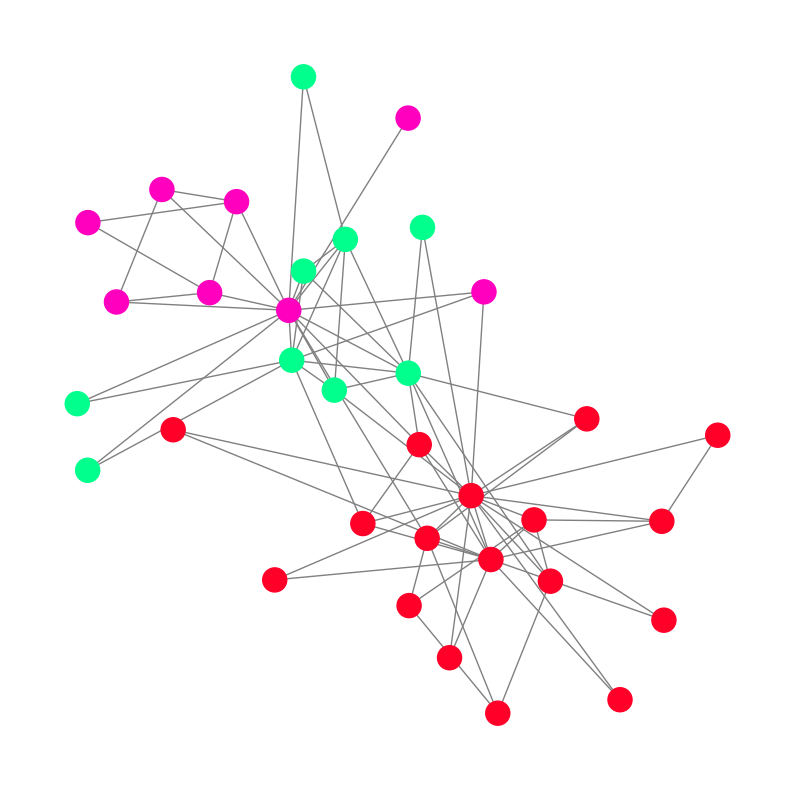

In [9]:
_ = draw_kkl(g, None, colors, cmap='gist_rainbow', edge_color='gray')

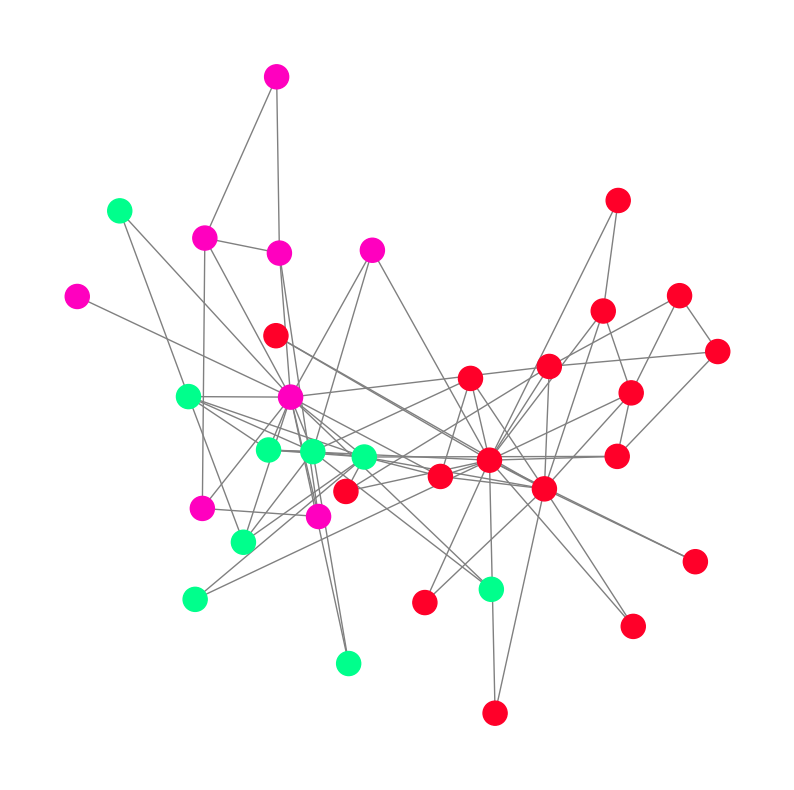

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(g, k=5/np.sqrt(g.number_of_nodes()))
kwargs = {"cmap": 'gist_rainbow', "edge_color":'gray'}
nx.draw(
    g, pos, with_labels=False,
    node_color=colors,
    ax=ax, **kwargs)
#plt.savefig('karate_club_graph.png', bbox_inches='tight', transparent=True)

In [16]:
# Convert NetworkX graph to NumPy adjacency matrix
A = np.asarray(nx.adjacency_matrix(g).todense())
print("Adjacency Matrix A:")
print(A)
print(f"\nShape: {A.shape}")
print(f"Number of edges: {int(A.sum() / 2)}")  # Divide by 2 for undirected graph

Adjacency Matrix A:
[[0 4 5 ... 2 0 0]
 [4 0 6 ... 0 0 0]
 [5 6 0 ... 0 2 0]
 ...
 [2 0 0 ... 0 4 4]
 [0 0 2 ... 4 0 5]
 [0 0 0 ... 4 5 0]]

Shape: (34, 34)
Number of edges: 231


In [17]:
A_mod = A + np.eye(g.number_of_nodes()) # add self-connections

D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())


D_mod_invroot = np.linalg.inv(sqrtm(D_mod))

A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

In [18]:
X = np.eye(g.number_of_nodes())

Great resource for handling matrices/vectors/dots/transposes when deriving gradient equations:  [Stanford CS224n Gradient Notes](https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf)

In [19]:
def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))


def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]


def norm_diff(dW, dW_approx):
    return np.linalg.norm(dW - dW_approx) / (np.linalg.norm(dW) + np.linalg.norm(dW_approx))


class GradDescentOptim():
    def __init__(self, lr, wd):
        self.lr = lr
        self.wd = wd
        self._y_pred = None
        self._y_true = None
        self._out = None
        self.bs = None
        self.train_nodes = None

    def __call__(self, y_pred, y_true, train_nodes=None):
        self.y_pred = y_pred
        self.y_true = y_true

        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes

        self.bs = self.train_nodes.shape[0]

    @property
    def out(self):
        return self._out

    @out.setter
    def out(self, y):
        self._out = y


class GCNLayer():
    def __init__(self, n_inputs, n_outputs, activation=None, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = activation
        self.name = name

    def __repr__(self):
        return f"GCN: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"

    def forward(self, A, X, W=None):
        """
        Assumes A is (bs, bs) adjacency matrix and X is (bs, D),
            where bs = "batch size" and D = input feature length
        """
        self._A = A
        self._X = (A @ X).T # for calculating gradients.  (D, bs)

        if W is None:
            W = self.W

        H = W @ self._X # (h, D)*(D, bs) -> (h, bs)
        if self.activation is not None:
            H = self.activation(H)
        self._H = H # (h, bs)
        return self._H.T # (bs, h)

    def backward(self, optim, update=True):
        dtanh = 1 - np.asarray(self._H.T)**2 # (bs, out_dim)
        d2 = np.multiply(optim.out, dtanh)  # (bs, out_dim) *element_wise* (bs, out_dim)

        self.grad = self._A @ d2 @ self.W # (bs, bs)*(bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)
        optim.out = self.grad

        dW = np.asarray(d2.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, D) -> (out_dim, D)
        dW_wd = self.W * optim.wd / optim.bs # weight decay update

        if update:
            self.W -= (dW + dW_wd) * optim.lr

        return dW + dW_wd


class SoftmaxLayer():
    def __init__(self, n_inputs, n_outputs, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.b = np.zeros((self.n_outputs, 1))
        self.name = name
        self._X = None # Used to calculate gradients

    def __repr__(self):
        return f"Softmax: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"

    def shift(self, proj):
        shiftx = proj - np.max(proj, axis=0, keepdims=True)
        exps = np.exp(shiftx)
        return exps / np.sum(exps, axis=0, keepdims=True)

    def forward(self, X, W=None, b=None):
        """Compute the softmax of vector x in a numerically stable way.

        X is assumed to be (bs, h)
        """
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b

        proj = np.asarray(W @ self._X) + b # (out, h)*(h, bs) = (out, bs)
        return self.shift(proj).T # (bs, out)

    def backward(self, optim, update=True):
        # should take in optimizer, update its own parameters and update the optimizer's "out"
        # Build mask on loss
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))

        # derivative of loss w.r.t. activation (pre-softmax)
        d1 = np.asarray((optim.y_pred - optim.y_true)) # (bs, out_dim)
        d1 = np.multiply(d1, train_mask) # (bs, out_dim) with loss of non-train nodes set to zero

        self.grad = d1 @ self.W # (bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)
        optim.out = self.grad

        dW = (d1.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, in_dim) -> (out_dim, in_dim)
        db = d1.T.sum(axis=1, keepdims=True) / optim.bs # (out_dim, 1)

        dW_wd = self.W * optim.wd / optim.bs # weight decay update

        if update:
            self.W -= (dW + dW_wd) * optim.lr
            self.b -= db.reshape(self.b.shape) * optim.lr

        return dW + dW_wd, db.reshape(self.b.shape)

In [20]:
gcn1 = GCNLayer(g.number_of_nodes(), 2, activation=np.tanh, name='1')
sm1 = SoftmaxLayer(2, n_classes, "SM")
opt = GradDescentOptim(lr=0, wd=1.)

In [21]:
gcn1_out = gcn1.forward(A_hat, X)
opt(sm1.forward(gcn1_out), labels)

## Gradient checking on Softmax layer

In [22]:
def get_grads(inputs, layer, argname, labels, eps=1e-4, wd=0):
    cp = getattr(layer, argname).copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        #print(f"Parm {argname}_{i}")
        theta_cp = theta

        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predp = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jp = xent(predp, labels).mean() + wd_term

        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predm = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jm = xent(predm, labels).mean() + wd_term

        # grad
        grads[i] = ((Jp - Jm) / (2*eps))

        # Back to normal
        cp_flat[i] = theta

    return grads.reshape(cp.shape)

In [23]:
dW_approx = get_grads((gcn1_out,), sm1, "W", labels, eps=1e-4, wd=opt.wd)
db_approx = get_grads((gcn1_out,), sm1, "b", labels, eps=1e-4, wd=opt.wd)

In [24]:
# Get gradients on Linear Softmax layer
dW, db = sm1.backward(opt, update=False)

In [25]:
assert norm_diff(dW, dW_approx) < 1e-7
assert norm_diff(db, db_approx) < 1e-7

## Gradient checking on GCN layer

In [26]:
def get_gcn_grads(inputs, gcn, sm_layer, labels, eps=1e-4, wd=0):
    cp = gcn.W.copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        theta_cp = theta

        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum()+(sm_layer.W.flatten()**2).sum()
        Jp = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2

        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum()+(sm_layer.W.flatten()**2).sum()
        Jm = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2

        # grad
        grads[i] = ((Jp - Jm) / (2*eps))

        # Back to normal
        cp_flat[i] = theta

    return grads.reshape(cp.shape)

In [27]:
dW2 = gcn1.backward(opt, update=False)

In [28]:
dW2_approx = get_gcn_grads((A_hat, X), gcn1, sm1, labels, eps=1e-4, wd=opt.wd)

In [29]:
assert norm_diff(dW2, dW2_approx) < 1e-7

## Gradient checking on inputs

In [30]:
def get_gcn_input_grads(A_hat, X, gcn, sm_layer, labels, eps=1e-4):
    cp = X.copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, x in enumerate(cp_flat):
        x_cp = x

        # J(theta + eps)
        cp_flat[i] = x + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(A_hat, cp_tmp))
        Jp = xent(pred, labels).mean()

        # J(theta - eps)
        cp_flat[i] = x - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(A_hat, cp_tmp))
        Jm = xent(pred, labels).mean()

        # grad
        grads[i] = ((Jp - Jm) / (2*eps))

        # Back to normal
        cp_flat[i] = x

    return grads.reshape(cp.shape)

In [31]:
dX_approx = get_gcn_input_grads(A_hat, X, gcn1, sm1, labels, eps=1e-4)

In [32]:
assert norm_diff(gcn1.grad/A_hat.shape[0], dX_approx) < 1e-7

# The Model

In [33]:
class GCNNetwork():
    def __init__(self, n_inputs, n_outputs, n_layers, hidden_sizes, activation, seed=0):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.hidden_sizes = hidden_sizes
        self.activation = activation

        np.random.seed(seed)

        self.layers = list()
        # Input layer
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], activation, name='in')
        self.layers.append(gcn_in)

        # Hidden layers
        for layer in range(n_layers):
            gcn = GCNLayer(self.layers[-1].W.shape[0], hidden_sizes[layer], activation, name=f'h{layer}')
            self.layers.append(gcn)

        # Output layer
        sm_out = SoftmaxLayer(hidden_sizes[-1], n_outputs, name='sm')
        self.layers.append(sm_out)

    def __repr__(self):
        return '\n'.join([str(l) for l in self.layers])

    def embedding(self, A, X):
        # Loop through all GCN layers
        H = X
        for layer in self.layers[:-1]:
            H = layer.forward(A, H)
        return np.asarray(H)

    def forward(self, A, X):
        # GCN layers
        H = self.embedding(A, X)

        # Softmax
        p = self.layers[-1].forward(H)

        return np.asarray(p)

In [34]:
gcn_model = GCNNetwork(
    n_inputs=g.number_of_nodes(),
    n_outputs=n_classes,
    n_layers=2,
    hidden_sizes=[16, 2],
    activation=np.tanh,
    seed=100,
)
gcn_model

GCN: W_in (34, 16)
GCN: W_h0 (16, 16)
GCN: W_h1 (16, 2)
Softmax: W_sm (2, 3)

In [35]:
y_pred = gcn_model.forward(A_hat, X)
embed = gcn_model.embedding(A_hat, X)
xent(y_pred, labels).mean()

np.float64(1.0763527735684253)

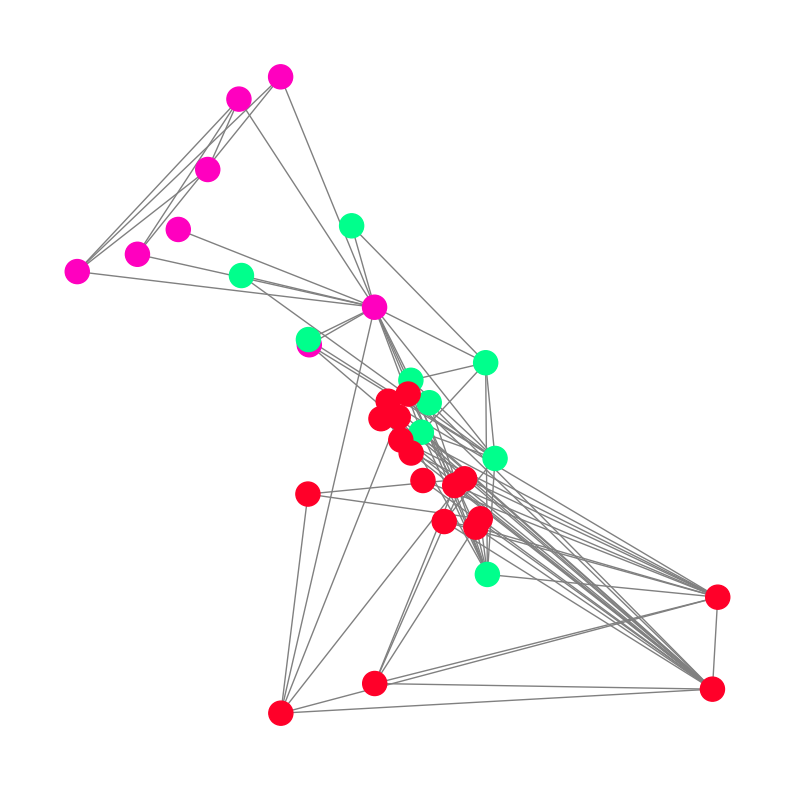

In [36]:
pos = {i: embed[i,:] for i in range(embed.shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

### Training

In [37]:
train_nodes = np.array([0, 1, 8])
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
opt2 = GradDescentOptim(lr=2e-2, wd=2.5e-2)

In [38]:
embeds = list()
accs = list()
train_losses = list()
test_losses = list()

loss_min = 1e6
es_iters = 0
es_steps = 50
# lr_rate_ramp = 0 #-0.05
# lr_ramp_steps = 1000

for epoch in range(15000):

    y_pred = gcn_model.forward(A_hat, X)

    opt2(y_pred, labels, train_nodes)

#     if ((epoch+1) % lr_ramp_steps) == 0:
#         opt2.lr *= 1+lr_rate_ramp
#         print(f"LR set to {opt2.lr:.4f}")

    for layer in reversed(gcn_model.layers):
        layer.backward(opt2, update=True)

    embeds.append(gcn_model.embedding(A_hat, X))
    # Accuracy for non-training nodes
    acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))[
        [i for i in range(labels.shape[0]) if i not in train_nodes]
    ]
    accs.append(acc.mean())

    loss = xent(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()

    train_losses.append(loss_train)
    test_losses.append(loss_test)

    if loss_test < loss_min:
        loss_min = loss_test
        es_iters = 0
    else:
        es_iters += 1

    if es_iters > es_steps:
        print("Early stopping!")
        break

    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")

train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

Epoch: 1, Train Loss: 1.089, Test Loss: 1.075
Epoch: 101, Train Loss: 1.050, Test Loss: 1.043
Epoch: 201, Train Loss: 1.004, Test Loss: 0.995
Epoch: 301, Train Loss: 0.940, Test Loss: 0.922
Epoch: 401, Train Loss: 0.850, Test Loss: 0.817
Epoch: 501, Train Loss: 0.734, Test Loss: 0.690
Epoch: 601, Train Loss: 0.609, Test Loss: 0.571
Epoch: 701, Train Loss: 0.498, Test Loss: 0.484
Epoch: 801, Train Loss: 0.407, Test Loss: 0.424
Epoch: 901, Train Loss: 0.333, Test Loss: 0.381
Epoch: 1001, Train Loss: 0.273, Test Loss: 0.349
Epoch: 1101, Train Loss: 0.226, Test Loss: 0.325
Epoch: 1201, Train Loss: 0.191, Test Loss: 0.308
Epoch: 1301, Train Loss: 0.165, Test Loss: 0.295
Epoch: 1401, Train Loss: 0.145, Test Loss: 0.286
Epoch: 1501, Train Loss: 0.129, Test Loss: 0.280
Epoch: 1601, Train Loss: 0.117, Test Loss: 0.275
Epoch: 1701, Train Loss: 0.108, Test Loss: 0.272
Epoch: 1801, Train Loss: 0.100, Test Loss: 0.269
Epoch: 1901, Train Loss: 0.094, Test Loss: 0.267
Epoch: 2001, Train Loss: 0.089, 

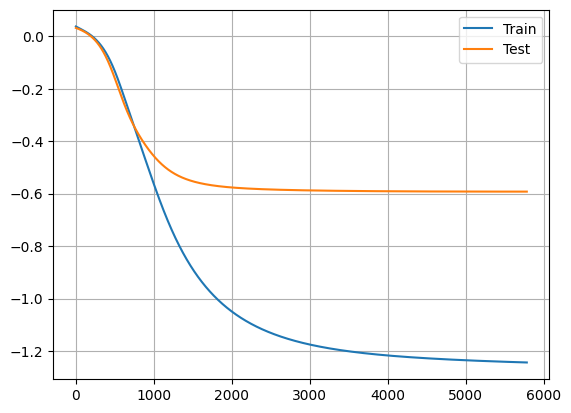

In [39]:
fig, ax = plt.subplots()
ax.plot(np.log10(train_losses), label='Train')
ax.plot(np.log10(test_losses), label='Test')
ax.legend()
ax.grid()

In [40]:
accs[-1]

np.float64(0.9032258064516129)

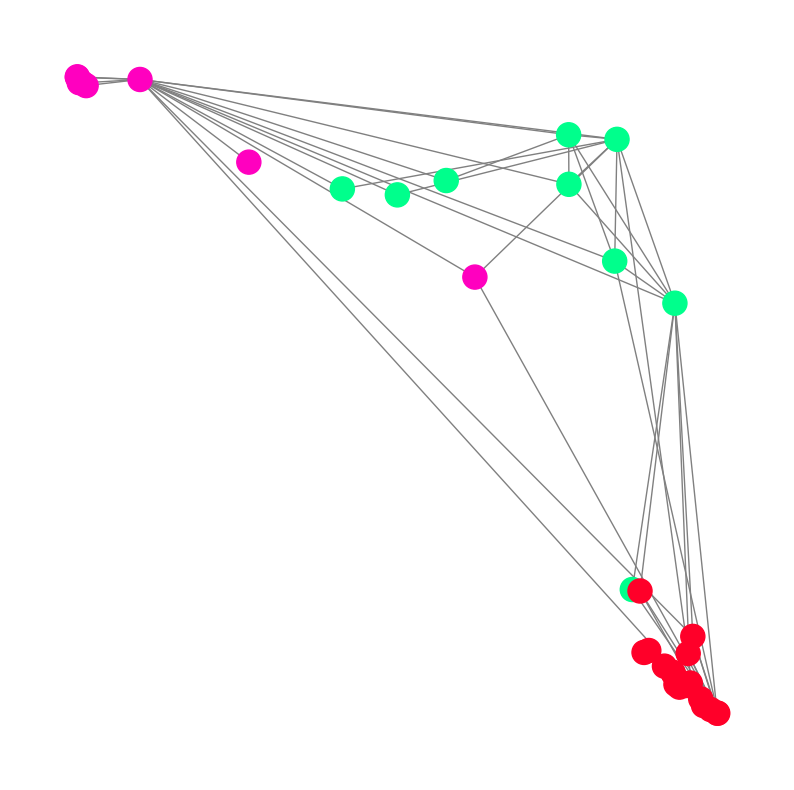

In [41]:
pos = {i: embeds[-1][i,:] for i in range(embeds[-1].shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

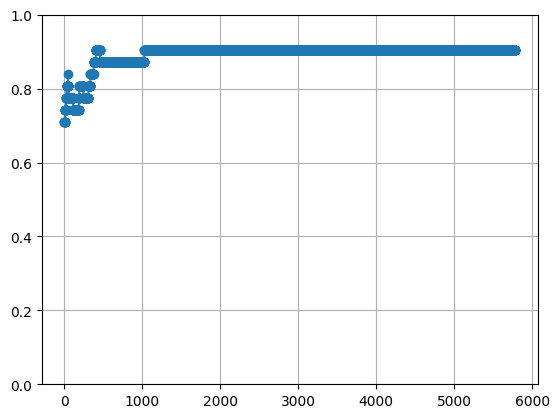

In [42]:
fig, ax = plt.subplots()
_ = ax.plot(accs, marker='o')
ax.grid()
_ = ax.set(ylim=[0,1])

In [43]:
N = 500
snapshots = np.linspace(0, len(embeds)-1, N).astype(int)

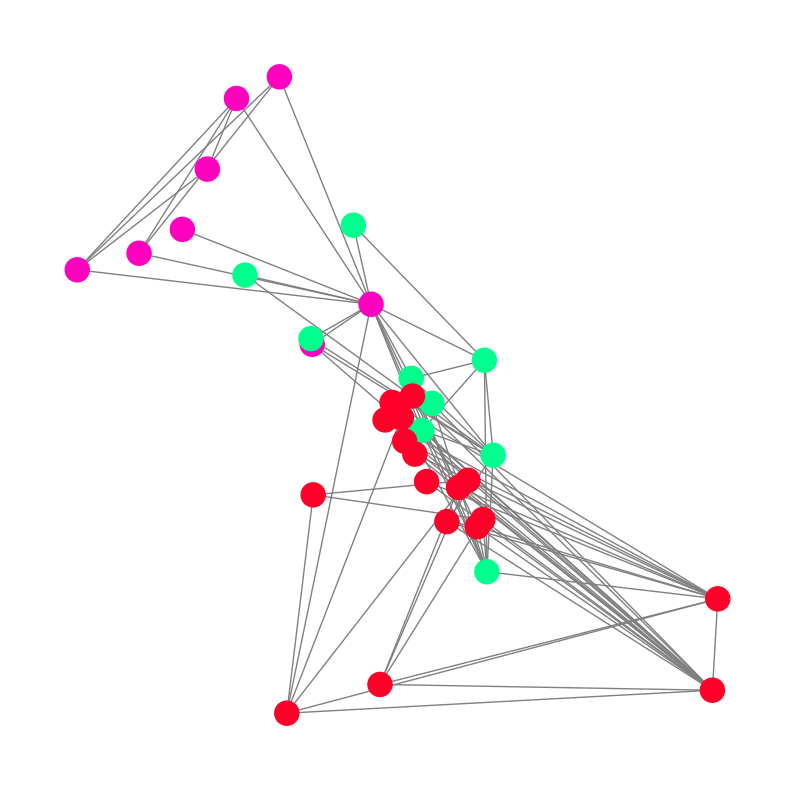

In [44]:
# Build plot
fig, ax = plt.subplots(figsize=(10, 10))
kwargs = {'cmap': 'gist_rainbow', 'edge_color': 'gray', }#'node_size': 55}

def update(idx):
    ax.clear()
    embed = embeds[snapshots[idx]]
    pos = {i: embed[i,:] for i in range(embed.shape[0])}
    nx.draw(g, pos, node_color=colors, ax=ax, **kwargs)

anim = animation.FuncAnimation(fig, update, frames=snapshots.shape[0], interval=10, repeat=False)

In [45]:
HTML(anim.to_html5_video())

In [ ]:
anim.save('embed_anim.mp4', dpi=300)